In [2]:
!pip install -q rouge-score
!pip install -q sacrebleu
!pip install -q evaluate
!pip install -q bert-score

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
from huggingface_hub import hf_hub_download, snapshot_download
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
import numpy as np
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
import evaluate
import os, json, shutil

### Setting up model on GPU and image transforms

#### Modifying config files

- The configuration files in the hugging face repo misses some of the details when defining the model's backbone architecture.
- We need to modify the files where it defined the backbone architecture before loading the model

In [ ]:
# !rm -rf ./fixed_model_files/
# !rm -rf ./fixed_model_files_patched/

In [4]:
model_path = "OpenGVLab/Mini-InternVL2-1B-DA-Medical"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# to modify lets download all the config files into the local directory
local_dir = './fixed_model_files'
print(f"Downloading configs and code fiels to {local_dir}")

snapshot_download(
    repo_id=model_path,
    local_dir=local_dir,
    allow_patterns=["*.json","*.py", "*.txt", "*.safetensors","*.bin"],
    local_dir_use_symlinks = False
)

# The issue is in the __init__ method accessing ['architectures'] on a default dictionary.
file_path = os.path.join(local_dir, "configuration_internvl_chat.py")

with open(file_path, 'r') as f:
    content = f.read()

# We replace the unsafe dictionary access with a safe .get() that defaults to Qwen2
# We check for both single and double quotes just in case.
unsafe_pattern_1 = "llm_config['architectures'][0]"
unsafe_pattern_2 = 'llm_config["architectures"][0]'
safe_pattern = "llm_config.get('architectures', ['Qwen2ForCausalLM'])[0]"

if unsafe_pattern_1 in content or unsafe_pattern_2 in content:
    print(f"Patching {file_path}...")
    content = content.replace(unsafe_pattern_1, safe_pattern)
    content = content.replace(unsafe_pattern_2, safe_pattern)

    with open(file_path, 'w') as f:
        f.write(content)
    print("Success: Python configuration file patched.")
else:
    print("Info: File appears to be already patched or pattern not found.")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

configuration_intern_vit.py: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

configuration_internvl_chat.py: 0.00B [00:00, ?B/s]

modeling_intern_vit.py: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

modeling_internvl_chat.py: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Patching ./fixed_model_files/configuration_internvl_chat.py...
Success: Python configuration file patched.


In [5]:
src_dir = './fixed_model_files'
dst_dir = './fixed_model_files_patched'

if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)
shutil.copytree(src_dir, dst_dir)

file_to_patch = os.path.join(dst_dir, "modeling_internvl_chat.py")

print(f"Patching {file_to_patch}...")
with open(file_to_patch, 'r') as f:
    content = f.read()

if "return_dict=return_dict," in content:
    # We replace it with a commented out version
    content = content.replace("return_dict=return_dict,", "# return_dict=return_dict,")

    with open(file_to_patch, 'w') as f:
        f.write(content)
    print("Success: 'return_dict' argument commented out.")
else:
    print("Warning: Could not find 'return_dict=return_dict,' string")

Patching ./fixed_model_files_patched/modeling_internvl_chat.py...
Success: 'return_dict' argument commented out.


In [6]:
print("Loading model using patched files from local directory")
tokenizer = AutoTokenizer.from_pretrained(dst_dir, trust_remote_code=True, use_fast=False)
model = AutoModel.from_pretrained(
    dst_dir,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    use_flash_attn=True
).to(device)
model.eval()

# setting the image token manually
model.img_context_token_id = tokenizer.convert_tokens_to_ids('<IMG_CONTEXT>')
print(f"IMG_CONTEXT_TOKEN ID set to: {model.img_context_token_id}")

# forcing 448x448 resolution for efficient batching
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
BATCH_SIZE = 32

def build_transform(input_size=448):
    return T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

transform = build_transform()

Loading model using patched files from local directory


`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.
IMG_CONTEXT_TOKEN ID set to: 151648


### Batch generation of data

In [7]:
def collate_fn(batch):
    images = []
    prompts = []
    raw_texts = []

    # InternVL represents a 448x448 image with exactly 256 visual tokens
    # We construct the sequence manually to ensure the tokenizer reserves the right space
    visual_tokens = "<img>" + "<IMG_CONTEXT>" * 256 + "</img>"

    for item in batch:
        # resizing the image
        image = item["image"]
        pixel_values = transform(image) # Shape: [3, 448, 448]
        images.append(pixel_values)

        # this is the standard InternVL prompt template
        question = "Describe this medical image."
        prompt = f"{visual_tokens}\n{question}"
        prompts.append(prompt)
        raw_texts.append(item["text"])

    # Stacking the images
    pixel_values = torch.stack(images)

    # tokenize the prompts with padding
    model_inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048
    )

    return model_inputs, pixel_values, raw_texts



In [8]:
# generating batched data
dataset = load_dataset("Fakhraddin/NLMCXR")
data = dataset["validation"]

eval_dataloader = DataLoader(data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

preds, refs = [], []
print(f"Starting generation with batch size: {BATCH_SIZE}...")

with torch.no_grad():
    for model_inputs, pixel_values, batch_texts in tqdm(eval_dataloader, desc="Generating"):
        input_ids = model_inputs["input_ids"].to(device)
        attention_mask = model_inputs["attention_mask"].to(device)

        # Ensure pixel_values match model dtype bfloat16 as model uses it
        pixel_values = pixel_values.to(device).to(torch.bfloat16)

        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            max_new_tokens=50,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )
        batch_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        preds.extend(batch_preds)
        refs.extend(batch_texts)

print(f"Generated {len(preds)} captions.")

README.md:   0%|          | 0.00/642 [00:00<?, ?B/s]

data/train-00000-of-00003-627ed4d457a264(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00001-of-00003-b7ef6c3b205887(…):   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00003-738198d486559e(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/validation-00000-of-00001-d17faea78(…):   0%|          | 0.00/273M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5925 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1505 [00:00<?, ? examples/s]

Starting generation with batch size: 32...


Generating: 100%|██████████| 48/48 [03:01<00:00,  3.79s/it]

Generated 1505 captions.


In [9]:
print(f"Evaluating {len(preds)} samples...")

# Cosine Similarity
print("Computing Cosine Similarity...")

#using bert-base-uncased for embeddings
eval_model_name = "bert-base-uncased"
eval_tokenizer = AutoTokenizer.from_pretrained(eval_model_name)
eval_model = AutoModel.from_pretrained(eval_model_name).to(device)
eval_model.eval()

def get_embeddings_batched(text_list, batch_size=128):
    """
    Computes CLS embeddings for a list of texts using batching to maximize GPU usage.
    """
    all_embs = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i : i + batch_size]
        inputs = eval_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = eval_model(**inputs)
        embs = outputs.last_hidden_state[:, 0, :].cpu()
        all_embs.append(embs)

    return torch.cat(all_embs, dim=0)

# Compute embeddings
pred_embs = get_embeddings_batched(preds)
ref_embs = get_embeddings_batched(refs)

# Compute Cosine Similarity
# cosine_similarity expects tensors of shape (N, D)
cosine_sims = torch.nn.functional.cosine_similarity(pred_embs, ref_embs, dim=1)
avg_cosine = cosine_sims.mean().item()

print(f"Done. Avg Cosine: {avg_cosine:.4f}")

#BLEU
print("Computing BLEU...")
# sacrebleu expects references as a list of lists (for multiple refs per image)
avg_bleu = corpus_bleu(preds, [refs]).score

#ROUGE score
print("Computing ROUGE...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for r, p in zip(refs, preds):
    scores = scorer.score(r, p)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

# BERT Score
print("Computing BERTScore...")
bertscore_metric = evaluate.load("bertscore")
results = bertscore_metric.compute(
    predictions=preds,
    references=refs,
    model_type="bert-base-uncased",
    batch_size=64,
    device=device
)

avg_bertscore = np.mean(results["f1"])

print("\n" + "="*40)
print(f"  Evaluation Report: InternVL2-1B Med DA")
print("="*40)
print(f"Avg. Cosine Similarity: {avg_cosine:.4f}")
print(f"Avg. BLEU:              {avg_bleu:.4f}")
print(f"Avg. ROUGE-1:           {avg_rouge1:.4f}")
print(f"Avg. ROUGE-2:           {avg_rouge2:.4f}")
print(f"Avg. ROUGE-L:           {avg_rougeL:.4f}")
print(f"Avg. BERTScore (F1):    {avg_bertscore:.4f}")
print("="*40)

Evaluating 1505 samples...
Computing Cosine Similarity...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Done. Avg Cosine: 0.4413
Computing BLEU...
Computing ROUGE...
Computing BERTScore...



  Evaluation Report: InternVL2-1B Med DA
Avg. Cosine Similarity: 0.4413
Avg. BLEU:              0.0002
Avg. ROUGE-1:           0.0132
Avg. ROUGE-2:           0.0006
Avg. ROUGE-L:           0.0108
Avg. BERTScore (F1):    0.0634


In [10]:
for i in range(5):
    print(f"Reference: {refs[i]}")
    print(f"Predictions: {preds[i]}\n")

Reference: 1. Increased opacity in the right upper lobe with XXXX associated atelectasis may represent focal consolidation or mass lesion with atelectasis. Recommend chest CT for further evaluation. 2. XXXX opacity overlying the left 5th rib may represent focal airspace disease. There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.
Predictions:  

A 64-year-old male patient with a history of chronic obstructive pulmonary disease was admitted to the emergency department with a cough and dyspnea. the patient was admitted to the emergency department with a cough and dyspnea. the patient

Reference: Status post left mastectomy. Heart size normal. Lungs are clear.
Predictions: 

Reference: No

### Plotting boxplot

/tmp/ipython-input-1523486056.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)


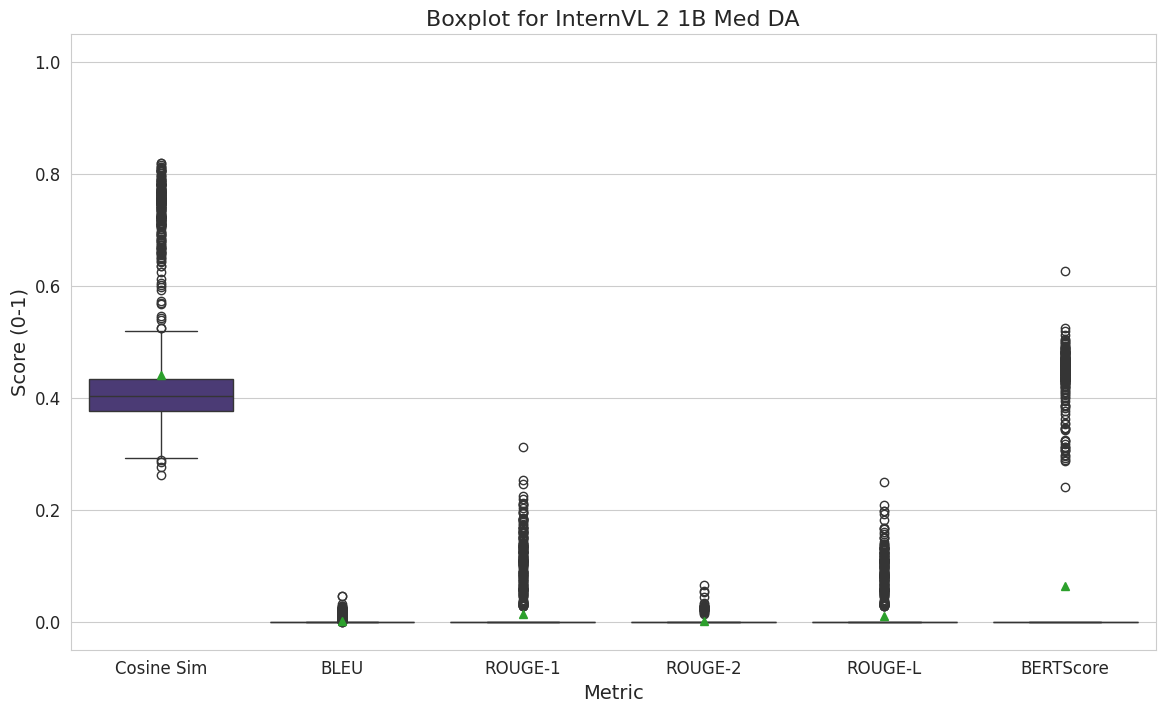


===== Statistical Summary =====
              mean     std     min     50%     max
Cosine Sim  0.4413  0.1218  0.2615  0.4033  0.8199
BLEU        0.0017  0.0049  0.0000  0.0000  0.0463
ROUGE-1     0.0132  0.0404  0.0000  0.0000  0.3125
ROUGE-2     0.0006  0.0042  0.0000  0.0000  0.0652
ROUGE-L     0.0108  0.0325  0.0000  0.0000  0.2500
BERTScore   0.0634  0.1556  0.0000  0.0000  0.6267


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sacrebleu import sentence_bleu


cosine_scores = cosine_sims.cpu().numpy()
bert_scores = results["f1"]

# calculating Sentence-Level BLEU for distribution
bleu_scores = []
for p, r in zip(preds, refs):
    # normalizing to 0-1 to match othewith otherr metrics on graph
    score = sentence_bleu(p, [r]).score
    bleu_scores.append(score / 100.0)

# dataframe for all metrics
df_metrics = pd.DataFrame({
    "Cosine Sim": cosine_scores,
    "BLEU": bleu_scores,
    "ROUGE-1": rouge1_scores,
    "ROUGE-2": rouge2_scores,
    "ROUGE-L": rougeL_scores,
    "BERTScore": bert_scores
})

#Plotting
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Transforming data to long format for Seaborn
df_melted = df_metrics.melt(var_name="Metric", value_name="Score")
ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)
plt.title("Boxplot for InternVL 2 1B Med DA", fontsize=16)
plt.ylabel("Score (0-1)", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print("\n===== Statistical Summary =====")
print(df_metrics.describe().T[['mean', 'std', 'min', '50%', 'max']].round(4))